# Deterministic Pursuit-Only Dynamics

- The predator accelerates in a straight line towards the prey
- The predator has higher speed than the prey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import math

## Parameters

## Starting conditions

In [2]:
# time: t in {0, ... n_steps}
# agents: 0=predator, 1=prey;
# feature: 0=x, 1=x',2=x'' 
# dims 2D

def get_trajectory(deg: float, params: dict):
    
    state = np.zeros((params['n_steps'], 2, 3, 2), dtype=float)

    # initial predator pos, vel, acc
    state[0, 0, 0] = [0, 0] 
    state[0, 0, 1] = [0, 0] 
    state[0, 0, 2] = [0, 0] 

    rad = np.deg2rad(deg) 

    # initial prey pos, vel, acc
    state[0, 1, 0] = [1, 0]
    state[0, 1, 1] = [np.sin(rad) * params['11_max'], np.cos(rad) * params['11_max']]
    state[0, 1, 2] = [0, 0] 
    
    return state

In [3]:
def normalize(v):
    length = np.linalg.norm(v)
    if length == 0:
        return np.zeros_like(v)
    return v / length

def rotate_right_90(v):
    """Rotate a 2D vector 90 degrees to the right (clockwise)."""
    return np.array([v[1], -v[0]])

def step(state, t, dt, pred_maxspeed, prey_maxspeed):
    """
    Update position and velocity for timestep t based on previous state.
    Applies max speed limits separately for predator (agent 0) and prey (agent 1).
    """
    # Position update
    state[t, :, 0, :] = state[t-1, :, 0, :] + state[t-1, :, 1, :] * dt

    # Velocity update
    state[t, :, 1, :] = state[t-1, :, 1, :] + state[t-1, :, 2, :] * dt

    # Limit predator speed
    pred_speed = np.linalg.norm(state[t, 0, 1, :])
    if pred_speed > pred_maxspeed:
        state[t, 0, 1, :] = state[t, 0, 1, :] / pred_speed * pred_maxspeed

    # Limit prey speed
    prey_speed = np.linalg.norm(state[t, 1, 1, :])
    if prey_speed > prey_maxspeed:
        state[t, 1, 1, :] = state[t, 1, 1, :] / prey_speed * prey_maxspeed

    return state


In [4]:
def simulate(state, params):
    """
    Run the simulation and return the final state tensor.
    state: (n_steps, 2 agents, 3 features, 2 dims)
    params: dictionary containing simulation parameters
    """
    n_steps = state.shape[0]
    dt = params["dt"]

    for t in range(1, n_steps):
        distance = np.linalg.norm(state[t-1, 0, 0] - state[t-1, 1, 0])

        if distance < params["R_kill"]:
            # Cut the tensor: freeze everything after t
            # Set velocities and accelerations to zero at capture
            state[t, :, 1, :] = 0  # zero velocities
            state[t, :, 2, :] = 0  # zero accelerations

            # Cut the tensor after capture
            state = state[:t]
            break            
        elif distance < params["R_react"]:
            # Prey reacts: rotate predator-prey vector 90° right
            direction = state[t-1, 1, 0] - state[t-1, 0, 0]
            state[t-1, 1, 2, :] = normalize(rotate_right_90(direction)) * params["12_max"]

        # Predator always steers toward prey
        direction = state[t-1, 1, 0] - state[t-1, 0, 0]
        state[t-1, 0, 2, :] = normalize(direction) * params["02_max"]

        # Step positions and velocities
        step(state, t, dt, params["01_max"], params["11_max"])

    return state        

In [5]:
import matplotlib.pyplot as plt
import math

def plot_trajectories(state, params: dict, bound: int = 20, title=''):
    """
    Plots the 2D trajectories of predator and prey from the simulation state.
    Shows two subplots:
    - Left: Bounded by a fixed square if bound != -1.
    - Right: Automatically scaled to fit all data.
    Also draws 10 connecting lines between predator and prey at equispaced times.
    """
    state = state.copy()

    # Extract trajectories
    predator_traj = state[:, 0, 0, :]
    prey_traj = state[:, 1, 0, :]

    # Prepare connecting line indices
    n_steps = state.shape[0]
    indices = np.linspace(0, n_steps - 1, 10, dtype=int)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)
    
    if title == '':
        title = f'{params}'
    
    fig.suptitle(title, fontsize=14)

    for ax_idx, ax in enumerate(axes):
        ax.plot(predator_traj[:, 0], predator_traj[:, 1], label='Predator', color='red')
        ax.plot(prey_traj[:, 0], prey_traj[:, 1], label='Prey', color='green')
        ax.scatter(predator_traj[0, 0], predator_traj[0, 1], color='red', marker='o', label='Predator Start')
        ax.scatter(prey_traj[0, 0], prey_traj[0, 1], color='green', marker='o', label='Prey Start')
        ax.scatter(predator_traj[-1, 0], predator_traj[-1, 1], color='red', marker='x', label='Predator End')
        ax.scatter(prey_traj[-1, 0], prey_traj[-1, 1], color='green', marker='x', label='Prey End')

        for idx in indices:
            ax.plot(
                [predator_traj[idx, 0], prey_traj[idx, 0]],
                [predator_traj[idx, 1], prey_traj[idx, 1]],
                color='blue', linestyle='--', linewidth=0.8
            )

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid(True)

        if ax_idx == 0:
            ax.set_xlim(-bound, bound)
            ax.set_ylim(-bound, bound)
            ax.set_title('Bounded View')
        elif ax_idx == 1:
            all_positions = np.vstack([predator_traj, prey_traj])
            x_min, y_min = np.min(all_positions, axis=0)
            x_max, y_max = np.max(all_positions, axis=0)
            ax.set_xlim(x_min - 1, x_max + 1)
            ax.set_ylim(y_min - 1, y_max + 1)
            ax.set_title('Full View (Auto-scaled)')

    axes[1].legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

We plot some relevant metrics side by side to help understand the behavior of the trajectory in time:
- _Signed Distance_: we model the distance between prey and predator by multiplying it with a sign representing whether the predator is left or right of the predator: we use the cross product to compute the sign, and extract the with an <u>activation</u> function.
- _Derivative of Distance_: the rest of change of 'absolute' distance is telling of how effective the predator is at reaching the prey, so we model it.
- 

In [6]:
def signed_distance(state, activation=lambda x: np.sign(x)):
    distance = state[:, 0, 0, :] - state[:, 1, 0, :]

    prey_vel = state[:, 1, 1, :]
    cross_z = prey_vel[:, 0] * distance[:, 1] - prey_vel[:, 1] * distance[:, 0]
    return np.linalg.norm(distance, axis=1) * activation(cross_z)

def distance_derivative(state):
    predator_pos = state[:, 0, 0, :]
    prey_pos = state[:, 1, 0, :]
    distance = np.linalg.norm(predator_pos - prey_pos, axis=1)
    return np.gradient(distance)

def velocity_dot_product(state):
    predator_vel = state[:, 0, 1, :]
    prey_vel = state[:, 1, 1, :]
    return np.einsum('ij,ij->i', predator_vel, prey_vel)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

def plot_combined_analysis(state, params: dict, bound: int = 20, title='', analysis_fns=None):
    """
    Combined plotting function that shows:
    - Top row: Two trajectory plots side by side (bounded and auto-scaled)
    - Bottom section: Variable number of metric plots passed in via analysis_fns
    """
    state = state.copy()

    # Extract data for trajectory plots
    predator_pos = state[:, 0, 0, :]
    prey_pos = state[:, 1, 0, :]
    time = np.arange(state.shape[0])

    # Prepare connecting line indices
    n_steps = state.shape[0]
    indices = np.linspace(0, n_steps - 1, 10, dtype=int)

    if analysis_fns is None:
        analysis_fns = []

    n_metrics = len(analysis_fns)
    total_rows = 1 + n_metrics

    fig = plt.figure(figsize=(16, 3 + 2.5 * total_rows))
    gs = gridspec.GridSpec(total_rows, 2, height_ratios=[2.5] + [1.0] * n_metrics)

    # Title
    if title == '':
        title = f'{params}'
    fig.suptitle(title, fontsize=16, y=0.99, va='top')

    # Trajectory plots
    ax_bounded = fig.add_subplot(gs[0, 0])
    ax_autoscaled = fig.add_subplot(gs[0, 1])

    for ax_idx, ax in enumerate([ax_bounded, ax_autoscaled]):
        ax.plot(predator_pos[:, 0], predator_pos[:, 1], label='Predator', color='red')
        ax.plot(prey_pos[:, 0], prey_pos[:, 1], label='Prey', color='green')
        ax.scatter(predator_pos[0, 0], predator_pos[0, 1], color='red', marker='o', label='Predator Start')
        ax.scatter(prey_pos[0, 0], prey_pos[0, 1], color='green', marker='o', label='Prey Start')
        ax.scatter(predator_pos[-1, 0], predator_pos[-1, 1], color='red', marker='x', label='Predator End')
        ax.scatter(prey_pos[-1, 0], prey_pos[-1, 1], color='green', marker='x', label='Prey End')

        for idx in indices:
            ax.plot(
                [predator_pos[idx, 0], prey_pos[idx, 0]],
                [predator_pos[idx, 1], prey_pos[idx, 1]],
                color='blue', linestyle='--', linewidth=0.8
            )

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.grid(True)

        if ax_idx == 0:
            ax.set_xlim(-bound, bound)
            ax.set_ylim(-bound, bound)
            ax.set_title('Bounded View')
            ax.legend(loc='best')
        elif ax_idx == 1:
            all_positions = np.vstack([predator_pos, prey_pos])
            x_min, y_min = np.min(all_positions, axis=0)
            x_max, y_max = np.max(all_positions, axis=0)
            ax.set_xlim(x_min - 1, x_max + 1)
            ax.set_ylim(y_min - 1, y_max + 1)
            ax.set_title('Full View (Auto-scaled)')

    # Metric plots
    for i, (fn, metric_title, y_label) in enumerate(analysis_fns):
        ax = fig.add_subplot(gs[i + 1, :])  # removed sharex=ax_bounded
        metric = fn(state)

        # Ensure metric is a 1D array of correct length
        metric = np.asarray(metric).squeeze()
        if metric.ndim != 1 or metric.shape[0] != time.shape[0]:
            raise ValueError(f"Metric function '{metric_title}' returned invalid shape: {metric.shape}")

        ax.plot(time, metric, color='blue' if i%2 == 0 else 'black')
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1.0, alpha=0.5)
        ax.set_ylabel(y_label)
        ax.set_title(metric_title)
        ax.grid(True)

        if i < len(analysis_fns) - 1:
            ax.label_outer()  # Hide x-tick labels

    # Label the x-axis only on the last subplot
    ax.set_xlabel('Time')
    formatter = ticker.FuncFormatter(lambda x, _: f"{x * params['dt']}")
    ax.xaxis.set_major_formatter(formatter)
    
    fig.subplots_adjust(hspace=0.25, top=0.94, bottom=0.06, left=0.08, right=0.95)
    plt.show()


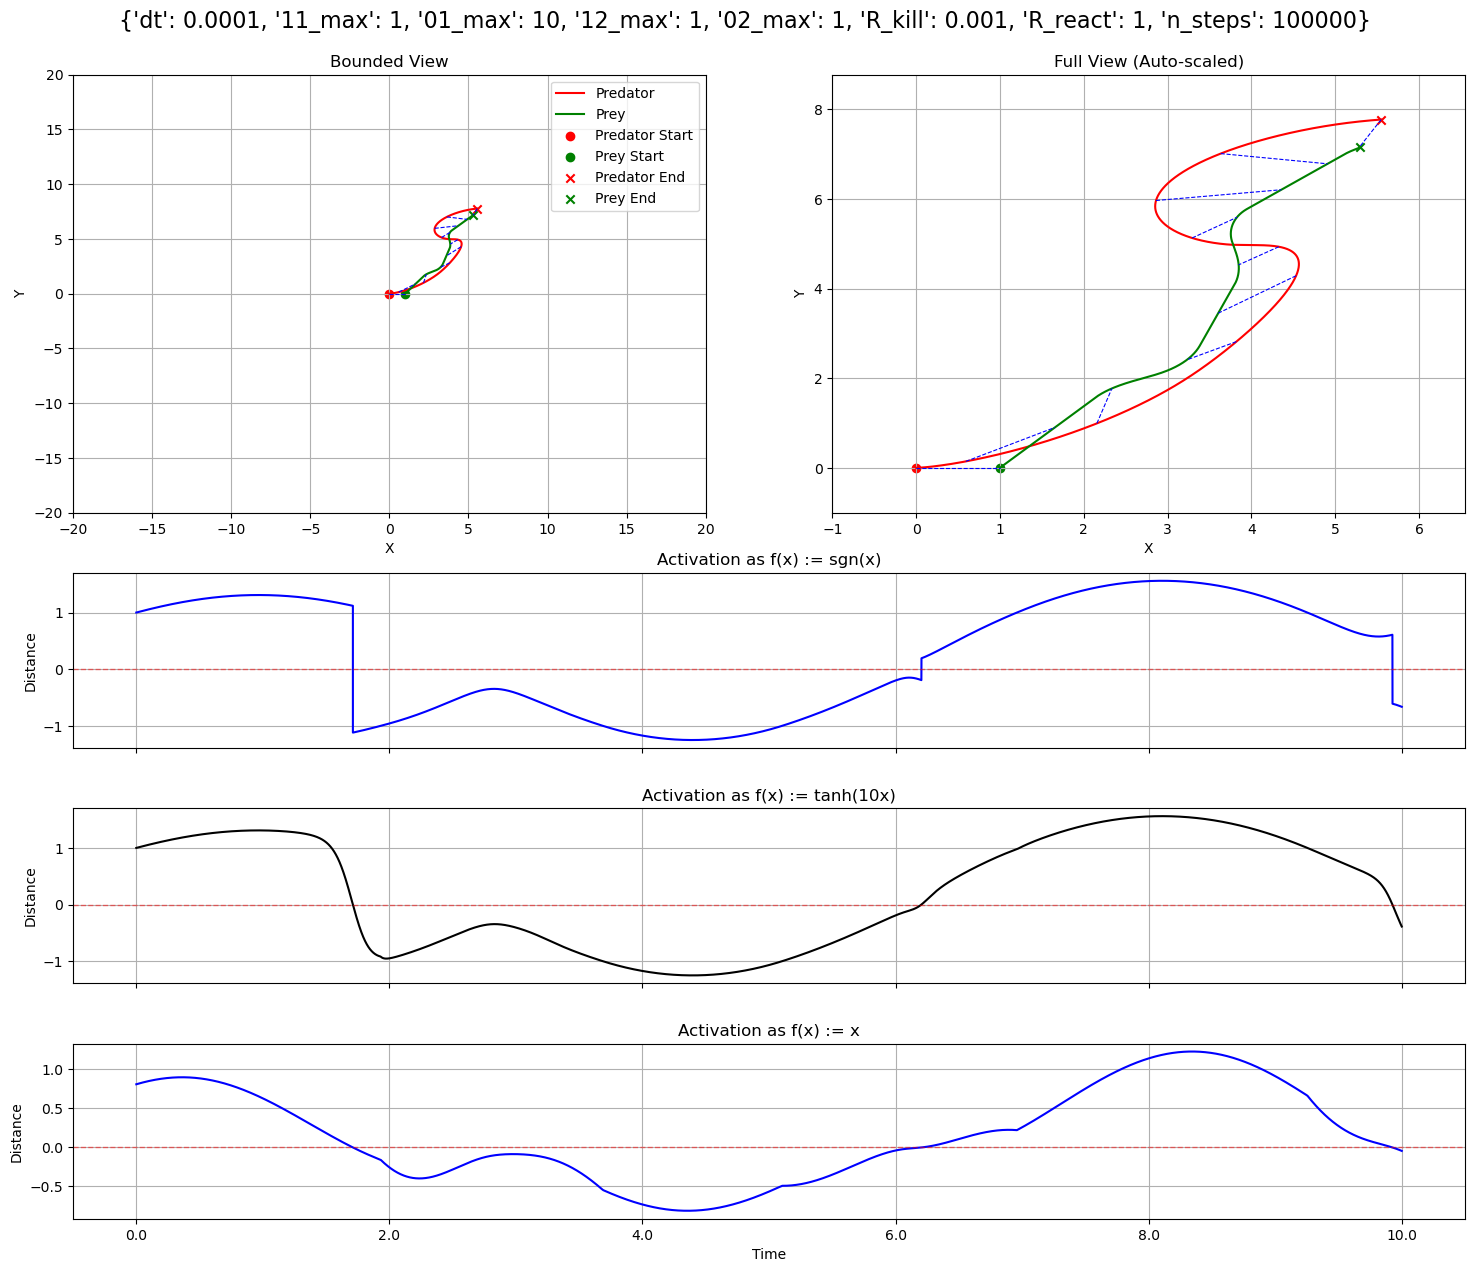

In [14]:
sign = lambda state : signed_distance(state, activation = lambda x: np.sign(x))
tanh = lambda state : signed_distance(state, activation = lambda x: np.tanh(10*x))
id = lambda state : signed_distance(state, activation = lambda x: x)

params = {
    "dt": 0.0001,
    
    "11_max": 1,
    "01_max": 10, # >
    
    "12_max": 1, # >
    "02_max": 1,
    
    "R_kill": 0.001,
    "R_react": 1,
}

distance = 10
bearing = 36
params['n_steps'] = round(distance / params['dt'])

state = get_trajectory(bearing, params)
simulate(state, params)

plot_combined_analysis(
    state,
    params=params,
    analysis_fns=[
        (sign, 'Activation as f(x) := sgn(x)', 'Distance'),
        (tanh, 'Activation as f(x) := tanh(10x)', 'Distance'),
        (id, 'Activation as f(x) := x', 'Distance'),
    ],
)

We notice a clear tradeoff between the regularity of the 'Signed Distance Function' and its fidelity in representing both sign and distance, depending on the activation function.

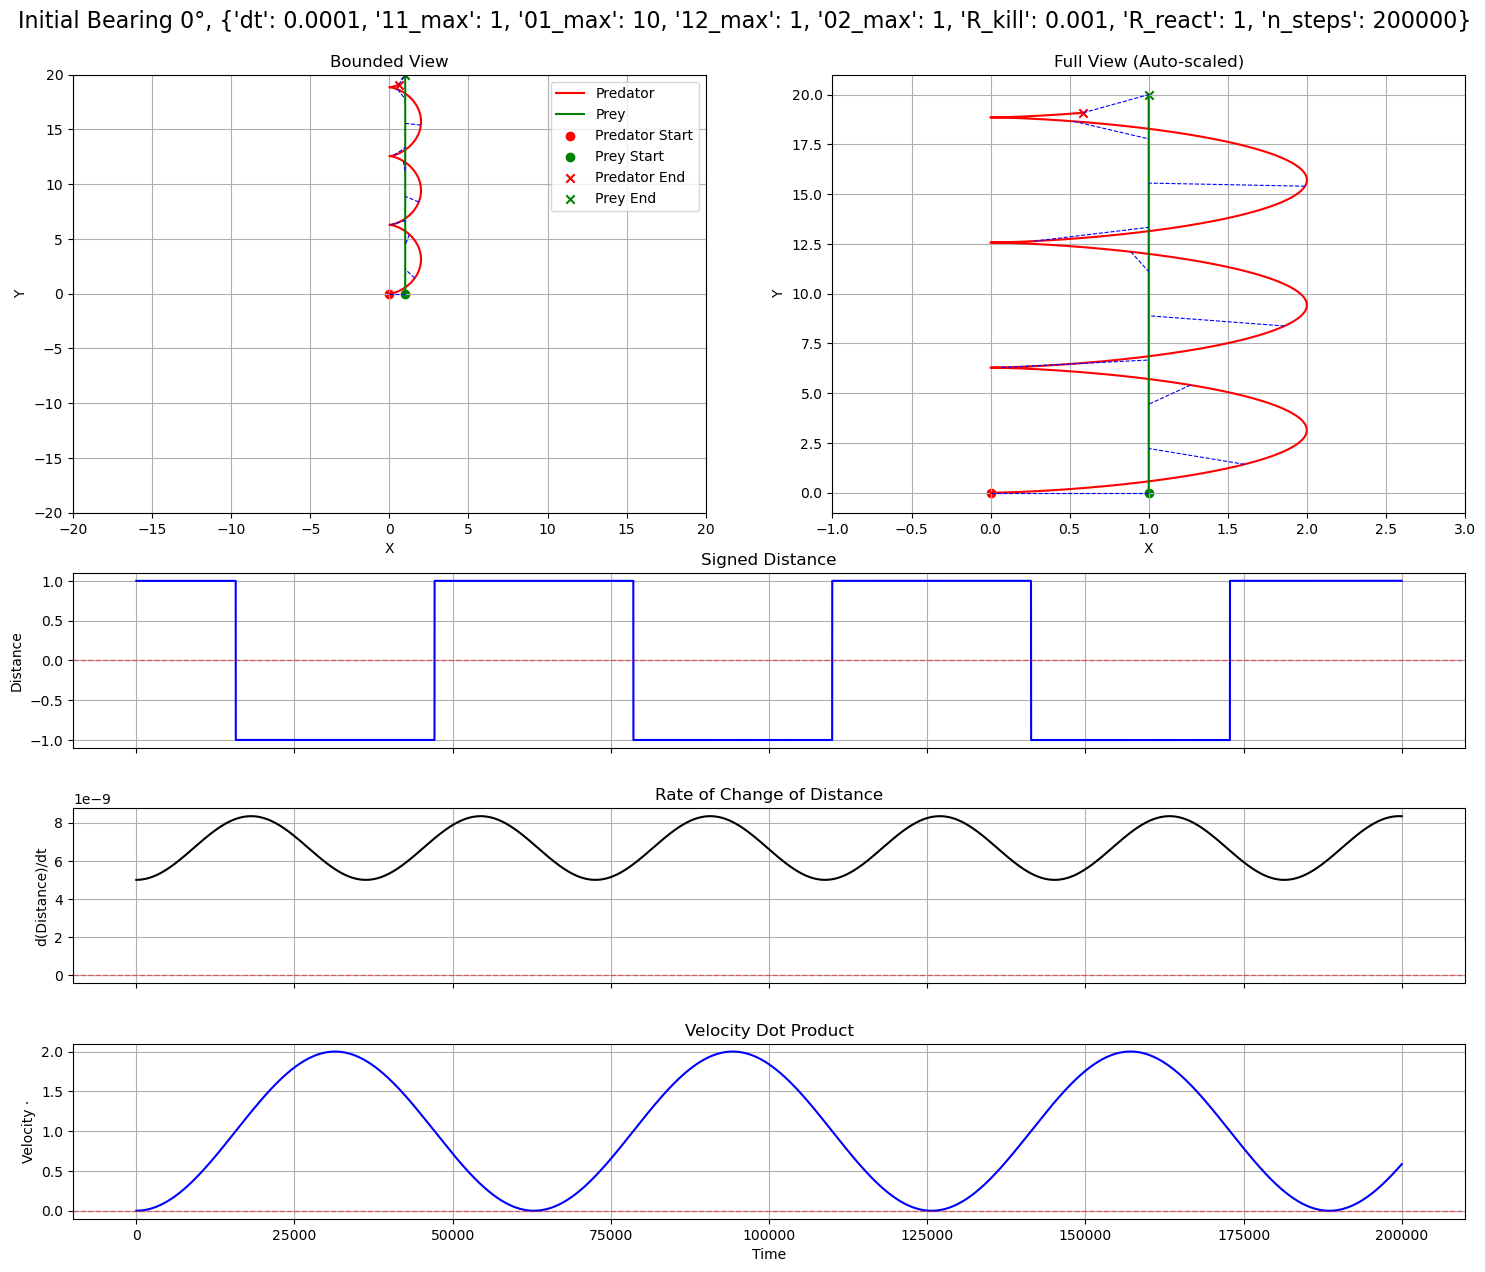

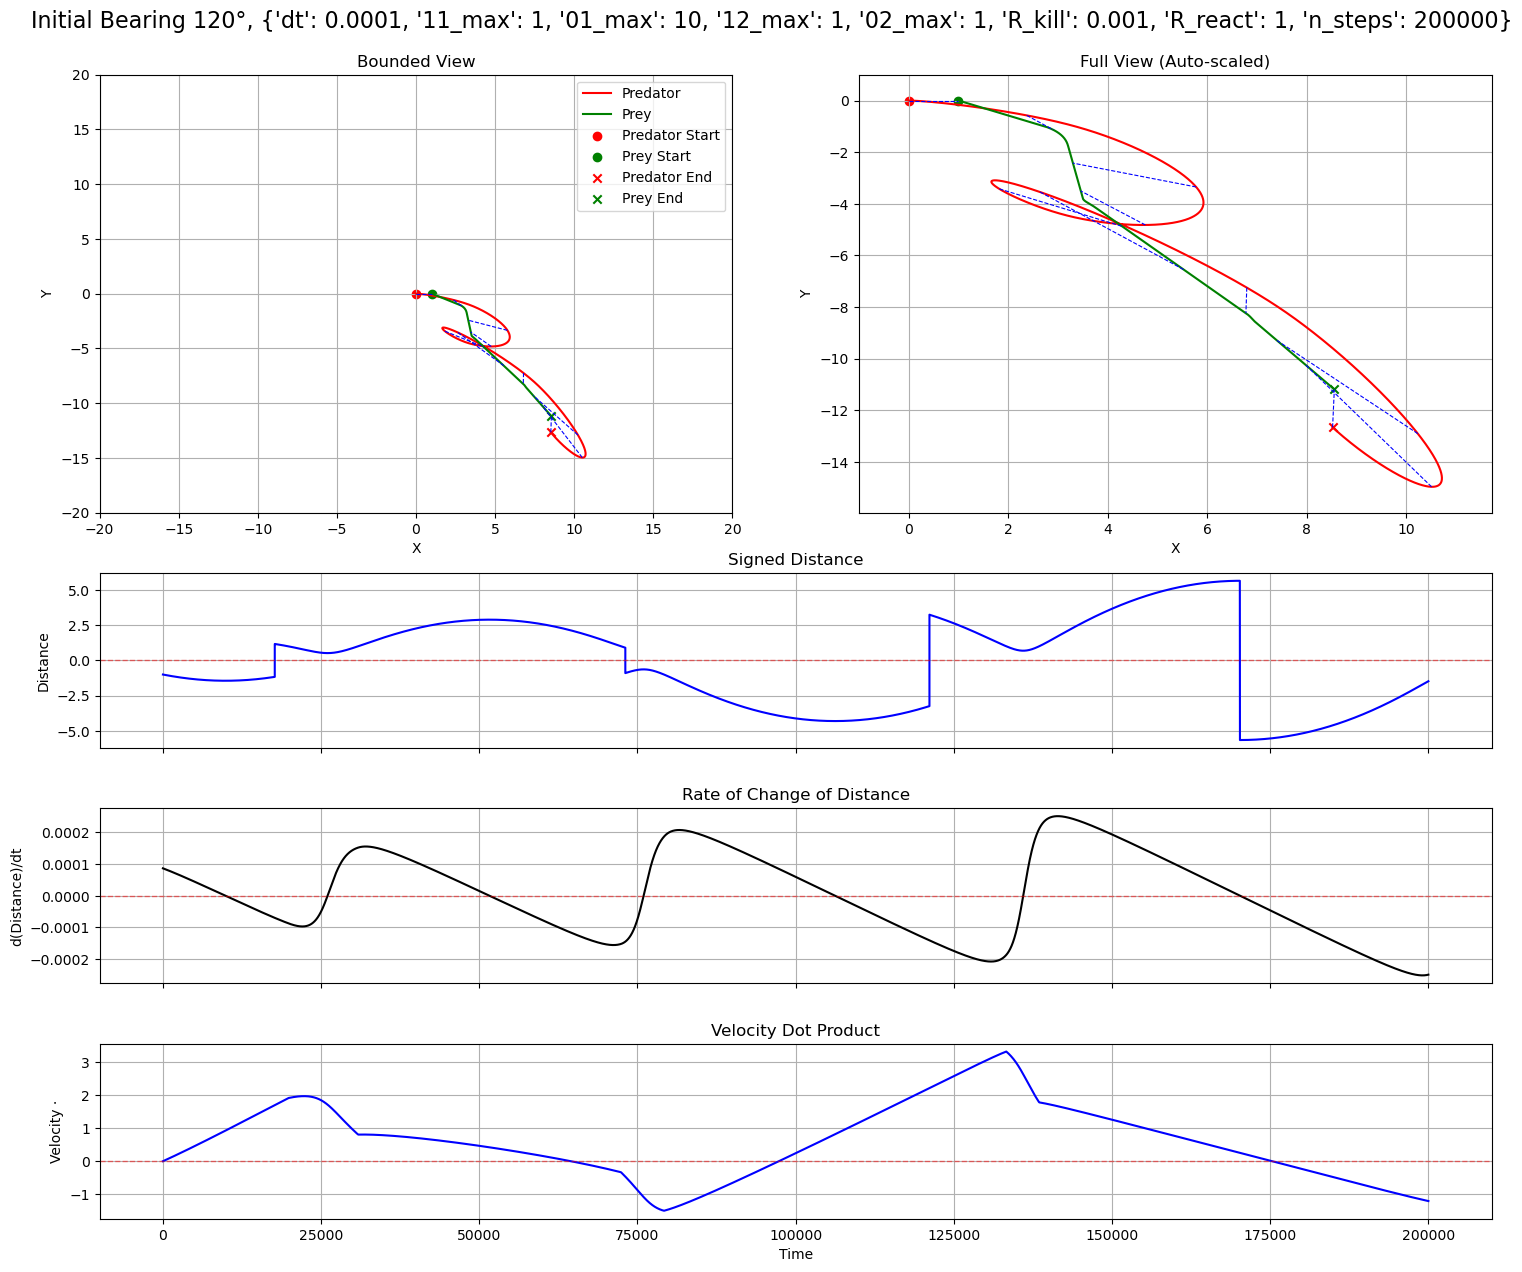

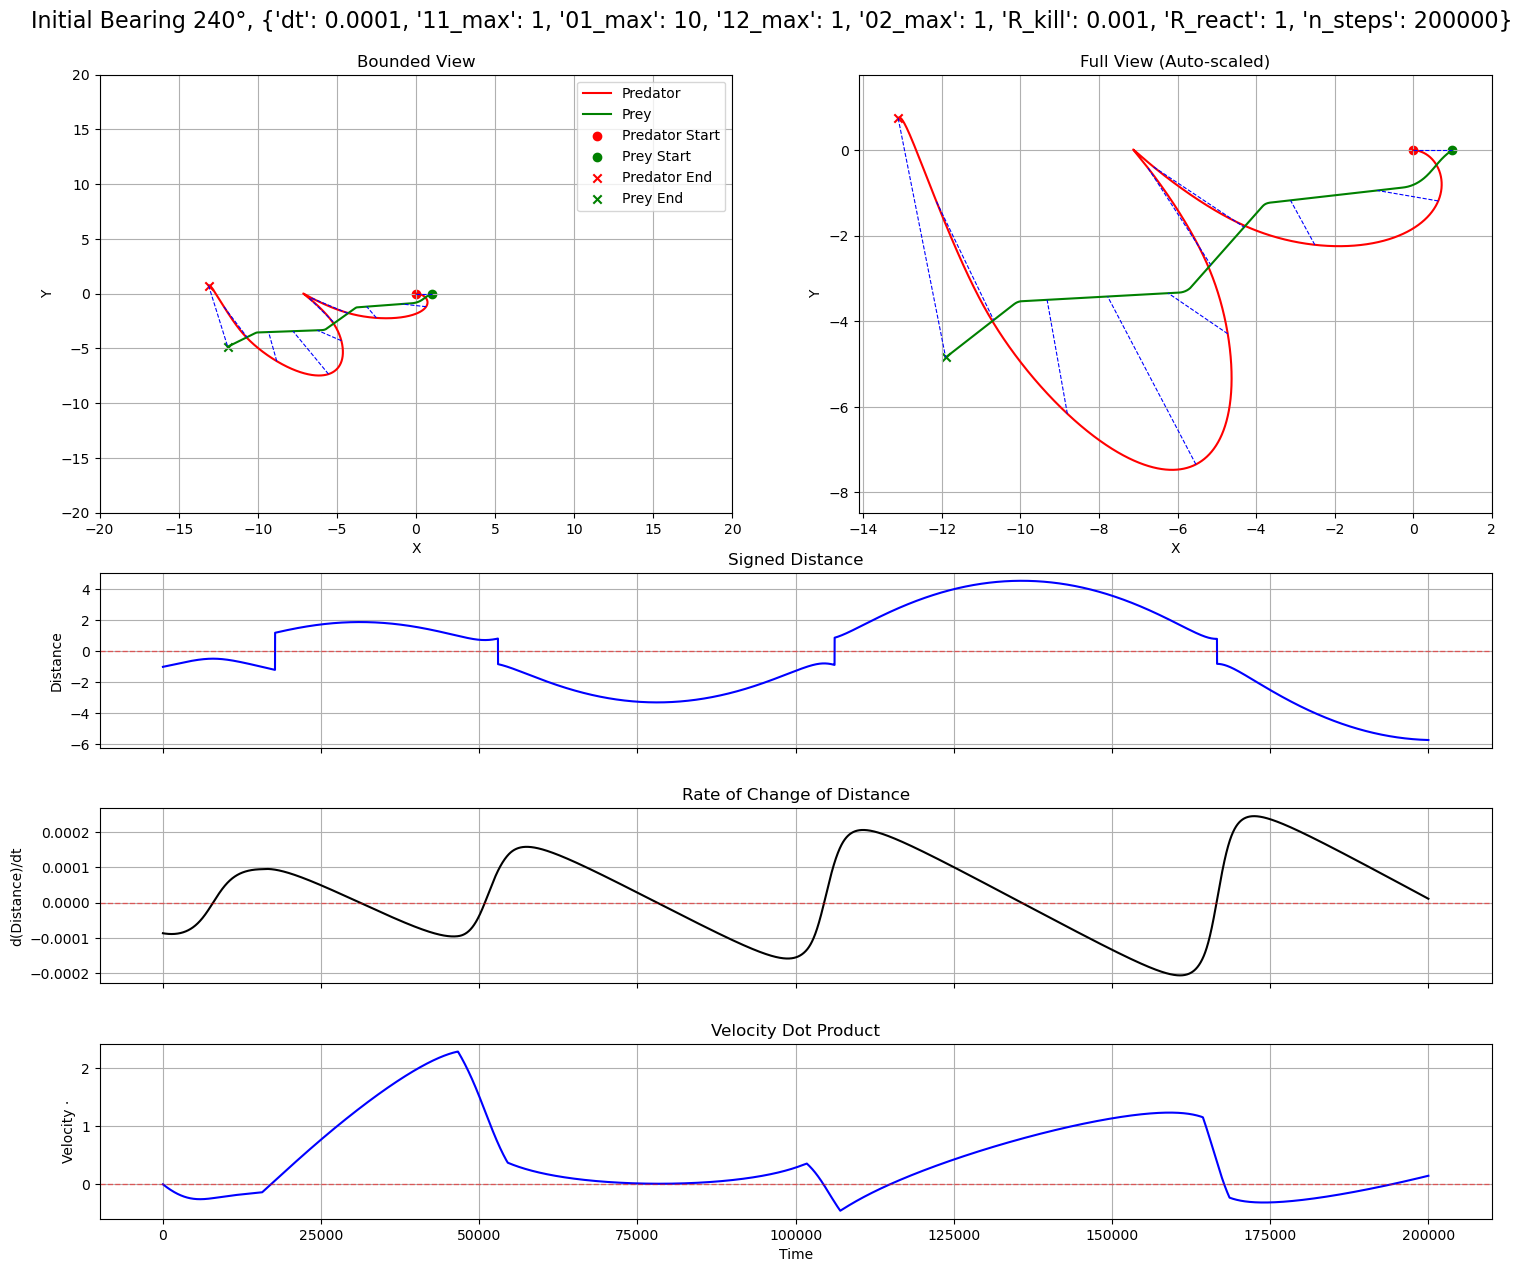

In [9]:
recordings = []
n = 3
distance = 20

for i in range(n):
    
    bearing = 360/n*i
    params['n_steps'] = round(distance / params['dt'])
    
    state = get_trajectory(bearing, params)
    simulate(state, params)
    recordings += [(params, state)]
    
    plot_combined_analysis(
        state,
        params=params,
        analysis_fns=[
            (signed_distance, 'Signed Distance', 'Distance'),
            (distance_derivative, 'Rate of Change of Distance', 'd(Distance)/dt'),
            (velocity_dot_product, 'Velocity Dot Product', 'Velocity ⋅')
        ],
        title = f'Initial Bearing {bearing:.0f}°, {params}'
    )

The presence of waves and a natural frequency suggests the need to use more advanced methods to understand the behavior, namely the Fourier transform.